In [21]:
import matplotlib.pyplot as plt
import datetime as dt
import pytz,os
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import scipy.optimize as opt
import yaml
import seaborn as sns

In [22]:
with open('site_settings.yml','r') as file:
    settings = yaml.safe_load(file)['observations']

{'obspack_folder': '../../observation_example_datasets//obspack_co2_1_GLOBALVIEWplus_v9.1_2023-12-08/data/nc/',
 'obspack_surface_code': 'co2_lef_tower-insitu_1_allvalid',
 'obspack_surface_heights': '30,122,396',
 'obspack_aircraft_code': 'co2_lef_aircraft-pfp_1_allvalid',
 'tccon_folder': '../../observation_example_datasets/tccon/',
 'tccon_site': 'pa',
 'ameriflux_file': '../../observation_example_datasets/AMF_US-PFa_BASE-BADM_28-5/AMF_US-PFa_BASE_HR_28-5.csv'}

# Analysis of LEF data
## Read in LEF in situ data and create afternoon averages for each day


In [23]:
utc = pytz.timezone('UTC')
local_tz = pytz.timezone('America/Chicago')
obspack_files = glob(os.path.join(settings['obspack_folder'], settings['obspack_surface_code']+'*'))
lef_is_all = {}
lef_is_day = {}
start_date = dt.datetime(2004,1,1)
end_date = dt.datetime(2022,1,1)
for fi in obspack_files:
    ht = fi.split('-')[-1].split('.nc')[0]
    print(ht)
    if not ht.split('magl')[0] in settings['obspack_surface_heights'].split(','): continue
    tmp = xr.open_dataset(fi,decode_timedelta=True)
    lef_is_all[ht] = pd.DataFrame({'co2':tmp['value'].data*1e6,'lat':tmp['latitude'].data,'lon':tmp['longitude']},index=tmp['time'].data)
    solar_time = np.array([lef_is_all[ht].index[i] + dt.timedelta(hours=lef_is_all[ht]['lon'].iloc[i]/180. * 12) for i in range(len(lef_is_all[ht].index))])
    lef_is_all[ht].index = solar_time[:]
    lef_is_all[ht] = lef_is_all[ht][start_date:end_date].dropna()
    
for ht in lef_is_all.keys():
    lef_is_day[ht] = lef_is_all[ht].between_time('12:00','16:00').groupby(pd.Grouper(freq='D')).mean()
    lef_is_day[ht].dropna()
    lef_is_day[ht] = lef_is_day[ht][start_date:end_date].dropna()


122magl
30magl
396magl


## Read in LEF in situ aircraft data and bin by altitude

In [24]:
aircraft_file = os.path.join(settings['obspack_folder'], settings['obspack_aircraft_code']+'.nc')
start_date = dt.datetime(2004,1,1)
end_date = dt.datetime(2022,1,1)

tmp = xr.open_dataset(aircraft_file,decode_timedelta=True)
alt_bin_edges = np.array([0,1000,2000,4000,10000])
alt_bin_centers = alt_bin_edges[:-1] + 0.5*np.diff(alt_bin_edges)
alt_ob = tmp['altitude'].data
alt_bin_inds = np.digitize(alt_ob,alt_bin_edges)-np.ones(len(alt_ob)).astype(int)
alt_binned = alt_bin_centers[alt_bin_inds]

lef_pfp = {}
for ialt in range(len(alt_bin_edges)-1):
    ht = alt_bin_edges[ialt+1]
    inds = np.where((alt_ob <= alt_bin_edges[ialt+1])*(alt_ob > alt_bin_edges[ialt]))
                                                       
    lef_pfp[ht] = pd.DataFrame({'co2':tmp['value'].data[inds]*1e6,'alt':tmp['altitude'].data[inds],'date':tmp['time'].data[inds],'lat':tmp['latitude'].data[inds],'lon':tmp['longitude'].data[inds]},index=tmp['time'].data[inds])
    solar_time = np.array([lef_pfp[ht].index[i] + dt.timedelta(hours=lef_pfp[ht]['lon'].iloc[i]/180. * 12) for i in range(len(lef_pfp[ht].index))])
    lef_pfp[ht].index = solar_time[:]
    lef_pfp[ht] = lef_pfp[ht][start_date:end_date].dropna()

## Read in LEF TCCON data

In [25]:
files = glob(settings['tccon_folder']+settings['tccon_site']+'*')
lef_tc_all = {}
lef_tc_day = {}
for fi in files:
    st = fi.split('/')[-1][:2]
    if st not in settings['tccon_site'].split(','): continue
    tmp = xr.open_dataset(fi,decode_timedelta=True)
    lef_tc_all[st] = pd.DataFrame({'xco2':tmp['xco2'].data,'lat':tmp['lat'].data,'lon':tmp['long'].data},index=pd.DatetimeIndex(tmp['time'].data))
    solar_time = np.array([lef_tc_all[st].index[i] + dt.timedelta(hours=int(lef_tc_all[st]['lon'].iloc[i]/180.) * 12) for i in range(len(lef_tc_all[st].index))])
    lef_tc_all[st].index = solar_time[:]
    date_inds = np.where((lef_tc_all[st].index > start_date)*(lef_tc_all[st].index < end_date))
    lef_tc_all[st] = lef_tc_all[st].iloc[date_inds].dropna()

for st in lef_tc_all.keys():
    lef_tc_day[st] = lef_tc_all[st].between_time('12:00','16:00').groupby(pd.Grouper(freq='D')).mean()
    lef_tc_day[st].dropna()
    date_inds = np.where((lef_tc_day[st].index > start_date)*(lef_tc_day[st].index < end_date))
    lef_tc_day[st] = lef_tc_day[st].iloc[date_inds].dropna()


## Plot full and afternoon averaged time series

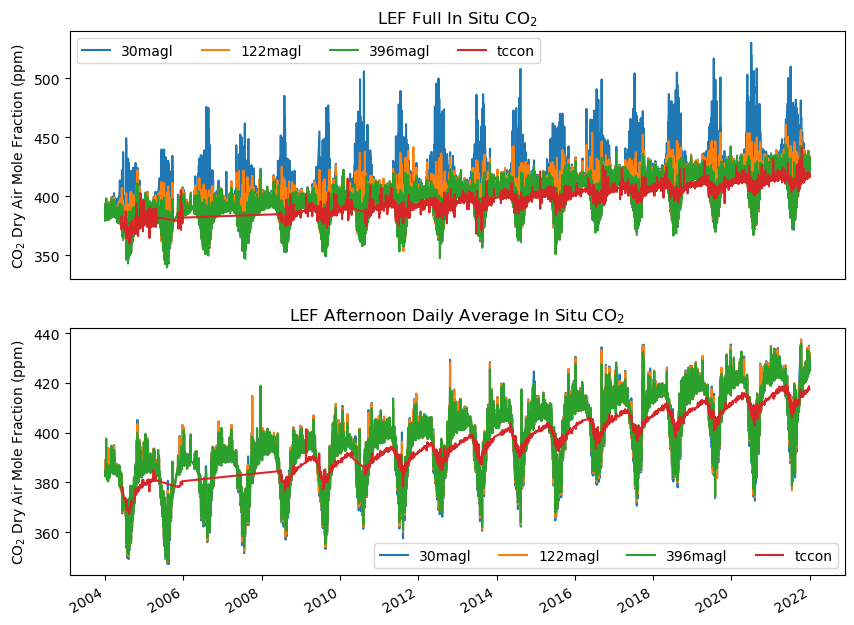

In [26]:
heights = sorted([int(ht) for ht in settings['obspack_surface_heights'].split(',')])
heights = [ f'{ht}magl' for ht in heights]

fig,axs = plt.subplots(2,1,figsize=(10,8))
labels = heights[:]
labels.append('tccon')
for ky in heights:
  lef_is_all[ky].co2.plot(title='LEF Full In Situ CO$_2$',ax=axs[0])
  lef_is_day[ky].co2.plot(title='LEF Afternoon Daily Average In Situ CO$_2$',ax=axs[1])
lef_tc_all['pa'].xco2.plot(ax=axs[0])
lef_tc_day['pa'].xco2.plot(ax=axs[1])

axs[0].legend(labels,ncol=4)
axs[0].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');
axs[0].set_xticks([])
xl = axs[1].get_xlim()
axs[0].set_xlim(xl)
axs[1].legend(labels,ncol=4)
axs[1].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');

#### Zoom in on a few recent years

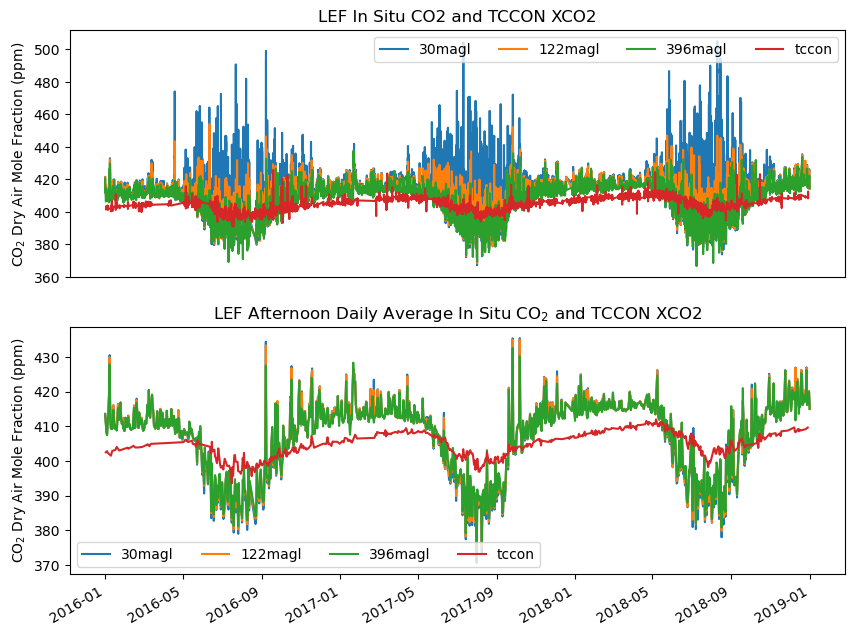

In [27]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
start_date = dt.datetime(2016,1,1)
end_date = dt.datetime(2019,1,1)
for ky in heights:
  lef_is_all[ky][start_date:end_date].co2.plot(title='LEF In Situ CO2 and TCCON XCO2',ax=axs[0])
  lef_is_day[ky][start_date:end_date].co2.plot(title='LEF Afternoon Daily Average In Situ CO$_2$ and TCCON XCO2',ax=axs[1])
date_inds = np.where((lef_tc_all['pa'].index > start_date)*(lef_tc_all['pa'].index < end_date))
lef_tc_all['pa'].iloc[date_inds].xco2.plot(ax=axs[0])
date_inds = np.where((lef_tc_day['pa'].index > start_date)*(lef_tc_day['pa'].index < end_date))
lef_tc_day['pa'].iloc[date_inds].xco2.plot(ax=axs[1])

axs[0].legend(labels,ncol=4)
axs[0].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');
axs[0].set_xticks([])
xl = axs[1].get_xlim()
axs[0].set_xlim(xl)
axs[1].legend(labels,ncol=4)
axs[1].set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');

## Questions
1. What happened to the "spikes" in the full data record when we only look at the daytime average data?
2. Are the "full" in situ and TCCON datasets really comparable? How are they different in terms of temporal coverage?
3. What data were filtered in the "day" TCCON dataset vs. "day" in situ dataset?

## Exploring variation with altitude

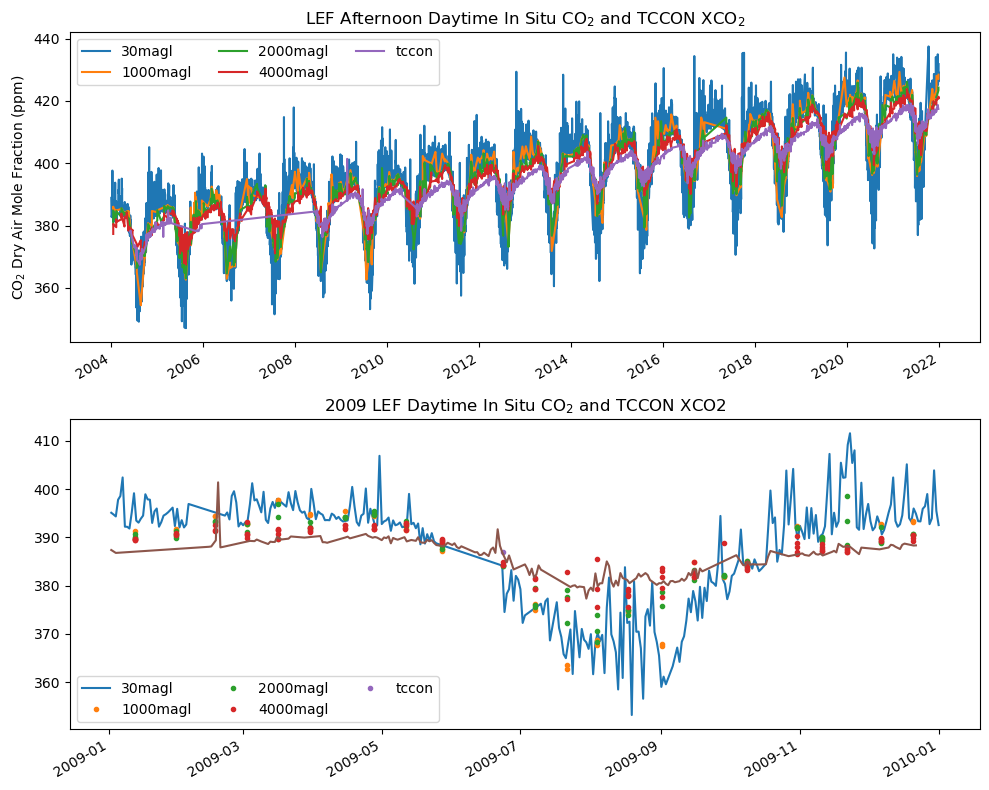

In [28]:
fig,axs = plt.subplots(2,1,figsize=(10,8))
labels = [heights[0]]
ax = axs[0]
lef_is_day['30magl'].co2.plot(title='LEF Afternoon Daytime In Situ CO$_2$ and TCCON XCO$_2$',ax=ax)

for alt in list(lef_pfp.keys())[:-1]:
    lef_pfp[alt].co2.plot(ax=ax)
    labels.append(f'{int(alt)}magl')
labels.append('tccon')
lef_tc_day['pa'].xco2.plot(ax=ax)
ax.legend(labels,ncol=3)
ax.set_ylabel(r'CO$_2$ Dry Air Mole Fraction (ppm)');
#ax.set_xticks([])

ax=axs[1]
start_date = dt.datetime(2009,1,1)
end_date = dt.datetime(2010,1,1)

lef_is_day['30magl'][start_date:end_date].co2.plot(title=f'{start_date.year} LEF Daytime In Situ CO$_2$ and TCCON XCO2',ax=ax)
for alt in alt_bin_edges[1:]:
    ax.plot(lef_pfp[alt][start_date:end_date].index,lef_pfp[alt][start_date:end_date].co2,'.')
    #lef_pfp.iloc[inds][start_date:end_date].reset_index().plot(x='index',y='co2',kind='scatter',ax=ax)

date_inds = np.where((lef_tc_day['pa'].index > start_date)*(lef_tc_day['pa'].index < end_date))
lef_tc_day['pa'].iloc[date_inds].xco2.plot(ax=ax)
ax.legend(labels,ncol=3)
fig.tight_layout()

## Fit a trend and seasonal cycle to the daytime data
### We treat the trend with a polynomial and the seasonality as a sinusoid:

Thoning fit: $f(t) = a_o + a_1 t + ... + a_n t^n + \Sigma_{i=1}^{nh} c_i \sin(2\pi i t + \phi_i)$

In [29]:
def thoning(x,*params):
  fout = 0.
  pn = params[:4]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  cn = params[4:]
  nh = len(cn)//2
  for i in range(nh):
    fout += cn[i]*np.sin(2*np.pi*(i+1)*x + cn[i+nh])
  return fout

def trend(x,*params):
  fout = 0.
  pn = params[:]
  for ip,p in enumerate(pn):
    fout += p*x**ip
  return fout

pt_is_all = {}
pt_is_day = {}
for ht in heights:
    tmp = lef_is_all[ht].dropna()
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    y = tmp.co2[:]
    p0 = np.array([300,10,1,1,20,20,20,20,0,0,0,0])
    pt_is_all[ht] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    lef_is_all[ht]['thoning'] = thoning(t,*pt_is_all[ht])
    lef_is_all[ht]['trend'] = thoning(t,*pt_is_all[ht][:4])
    
    tmp = lef_is_day[ht].dropna()
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in tmp.index])/86400./365.    
    y = tmp.co2[:]
    p0 = np.array([300,10,1,1,20,20,20,20,0,0,0,0])
    pt_is_day[ht] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    lef_is_day[ht]['thoning'] = thoning(t,*pt_is_day[ht])
    lef_is_day[ht]['trend'] = thoning(t,*pt_is_day[ht][:4])

pt_ac = {}
for ht in list(lef_pfp.keys())[:-1]:
    tmp = lef_pfp[ht].dropna()
    inds = np.where(tmp.index.year > 2004)
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    y = tmp.co2[:]
    p0 = np.array([300,10,1,1,20,20,20,20,0,0,0,0])
    pt_ac[ht] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    lef_pfp[ht]['thoning'] = thoning(t,*pt_ac[ht])
    lef_pfp[ht]['trend'] = thoning(t,*pt_ac[ht][:4])

pt_tc = {}
for st in ['pa']:
    tmp = lef_tc_day[st].dropna()
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in tmp.index])/86400./365.
    y = tmp.xco2[:]
    p0 = np.array([300,10,1,0,20,20,20,20,0,0,0,0])
    pt_tc[st] = opt.curve_fit(thoning,t,y,p0=p0,method='lm')[0]
    lef_tc_day[st]['thoning'] = thoning(t,*pt_tc[st])
    lef_tc_day[st]['trend'] = thoning(t,*pt_tc[st][:4])


## Daytime Data and Curve Fit

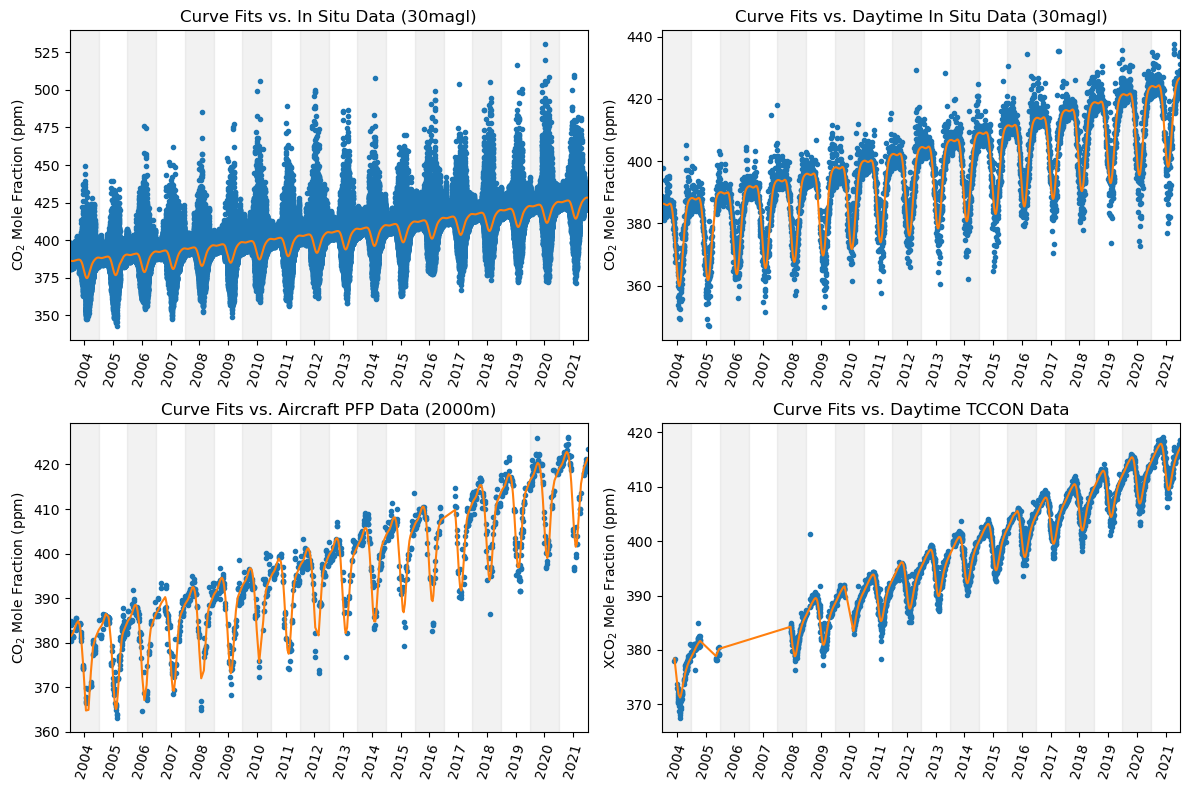

In [30]:
fig,axs = plt.subplots(2,2,figsize=(12,8))

ax = axs[0,0]
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_is_all[heights[0]].index])/86400./365.
ax.plot(t,lef_is_all[heights[0]]['co2'],'.')
ax.plot(t,lef_is_all[heights[0]]['thoning'])
ax.set_title(f'Curve Fits vs. In Situ Data ({heights[0]})')
ax.set_ylabel('CO$_2$ Mole Fraction (ppm)')
for i in range(0,22-4,2):
    ax.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
ax.set_xticks(np.arange(0.5,22-4,1),np.arange(2004,2022),rotation=75);
ax.set_xlim([0,18])

ax = axs[0,1]
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_is_day[heights[0]].index])/86400./365.
ax.plot(t,lef_is_day[heights[0]]['co2'],'.')
ax.plot(t,lef_is_day[heights[0]]['thoning'])
ax.set_title(f'Curve Fits vs. Daytime In Situ Data ({heights[0]})')
ax.set_ylabel('CO$_2$ Mole Fraction (ppm)')
for i in range(0,22-4,2):
    ax.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
ax.set_xticks(np.arange(0.5,22-4,1),np.arange(2004,2022),rotation=75);
ax.set_xlim([0,18])

ax = axs[1,0]
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_pfp[2000].index])/86400./365.
ax.plot(t,lef_pfp[2000]['co2'],'.')
ax.plot(t,lef_pfp[2000]['thoning'])
ax.set_title(f'Curve Fits vs. Aircraft PFP Data (2000m)')
ax.set_ylabel('CO$_2$ Mole Fraction (ppm)')
for i in range(0,22-4,2):
    ax.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
ax.set_xticks(np.arange(0.5,22-4,1),np.arange(2004,2022),rotation=75);
ax.set_xlim([0,18])

ax = axs[1,1]
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_tc_day['pa'].index])/86400./365.
ax.plot(t,lef_tc_day['pa']['xco2'],'.')
ax.plot(t,thoning(t,*pt_tc['pa']))
ax.set_title('Curve Fits vs. Daytime TCCON Data')
ax.set_ylabel('XCO$_2$ Mole Fraction (ppm)')
for i in range(0,22-4,2):
    ax.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
ax.set_xticks(np.arange(0.5,22-4,1),np.arange(2004,2022),rotation=75);
ax.set_xlim([0,18])

fig.tight_layout()

## Examination of Residuals

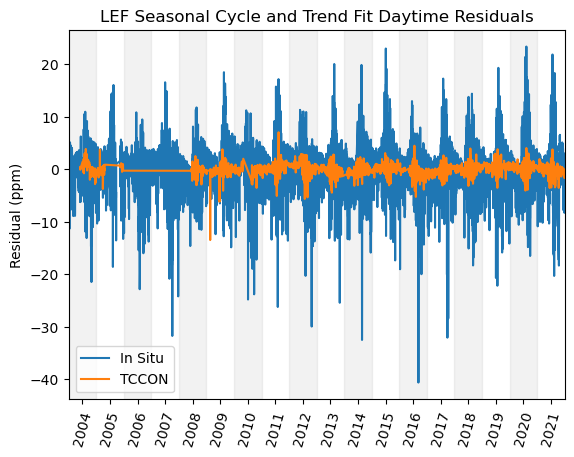

In [31]:
fig,ax = plt.subplots(1,1)
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_is_day[heights[0]].index])/86400./365.
g1 = ax.plot(t,thoning(t,*pt_is_day[heights[0]])-lef_is_day[heights[0]]['co2'])
t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_tc_day['pa'].index])/86400./365.
g2 = ax.plot(t,thoning(t,*pt_tc['pa'])-lef_tc_day['pa']['xco2'])
for i in range(0,22-4,2):
    ax.axvspan(i,i+1,0,1,color='grey',alpha=0.1)
ax.set_xticks(np.arange(0.5,22-4,1),np.arange(2004,2022),rotation=75);
ax.set_xlim([0,18])
ax.set_title('LEF Seasonal Cycle and Trend Fit Daytime Residuals')
ax.set_ylabel('Residual (ppm)')
ax.legend([g1[0],g2[0]],['In Situ','TCCON'])

## Questions

1. How do you interpret the parameters in the curve fits?
2. What do the large remaining variations in the fits versus the full time series represent?

# Seasonal Cycle Analysis

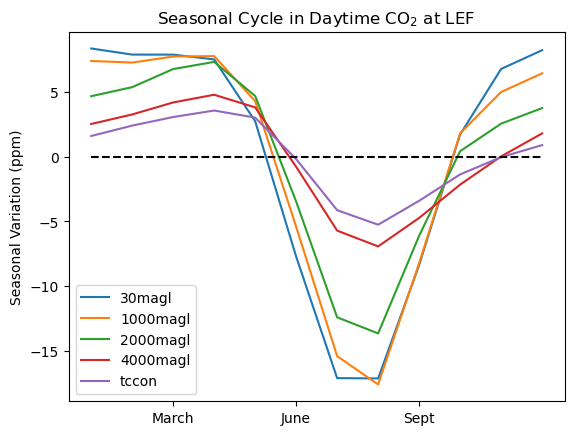

In [32]:
labels = [heights[0]]
fig,ax=plt.subplots(1,1)
for ky in heights[:1]:
    lef_is_day[ky]['detrend'] = lef_is_day[ky].thoning-lef_is_day[ky].trend
    seas = lef_is_day[ky].groupby(lef_is_day[ky]['co2'].index.month)['detrend'].mean()
    seas.plot(ax=ax)

for ky in list(lef_pfp.keys())[:-1]:
    lef_pfp[ky]['detrend'] = lef_pfp[ky].thoning-lef_pfp[ky].trend
    seas = lef_pfp[ky].groupby(lef_pfp[ky]['co2'].index.month)['detrend'].mean()
    seas.plot(ax=ax)
    labels.append(f'{ky}magl')

lef_tc_day['pa']['detrend'] = lef_tc_day['pa'].thoning-lef_tc_day['pa'].trend
seas_tc = lef_tc_day['pa'].groupby(lef_tc_day['pa']['xco2'].index.month)['detrend'].mean()
seas_tc.plot(ax=ax)
labels.append('tccon')

ax.legend(labels)
ax.set_title(f'Seasonal Cycle in Daytime CO$_2$ at LEF')
ax.set_ylabel('Seasonal Variation (ppm)')
ax.legend(labels)
#ax.set_ylim([-3,38])
ax.plot([1,12],[0,0],'--k')
ax.set_xticks([3,6,9],['March','June','Sept']);

## Questions
1. How does the seasonal cycle in the in situ data vary with altitude?
2. Why is the TCCON seasonal cycle lagged relative to the in situ data?

# Diurnal Cycle Analysis

### With detrended and deseasonalized data, we can start to examine other frequencies of variability.  The first place to look is changes over the course of a day from season to season.

## First create a detrended, deseasonalized time series by subtracting the Thoning fit to the daytime data. 

In [33]:
for h in heights:
    t = np.array([(ti-dt.datetime(2004,1,1)).total_seconds() for ti in lef_is_all[h].index])/86400./365.
    lef_is_all[h]['co2_de'] = lef_is_all[h].co2-thoning(t,*pt_is_day[h])

## Now use groupby to plot diurnal cycle for 4 different months

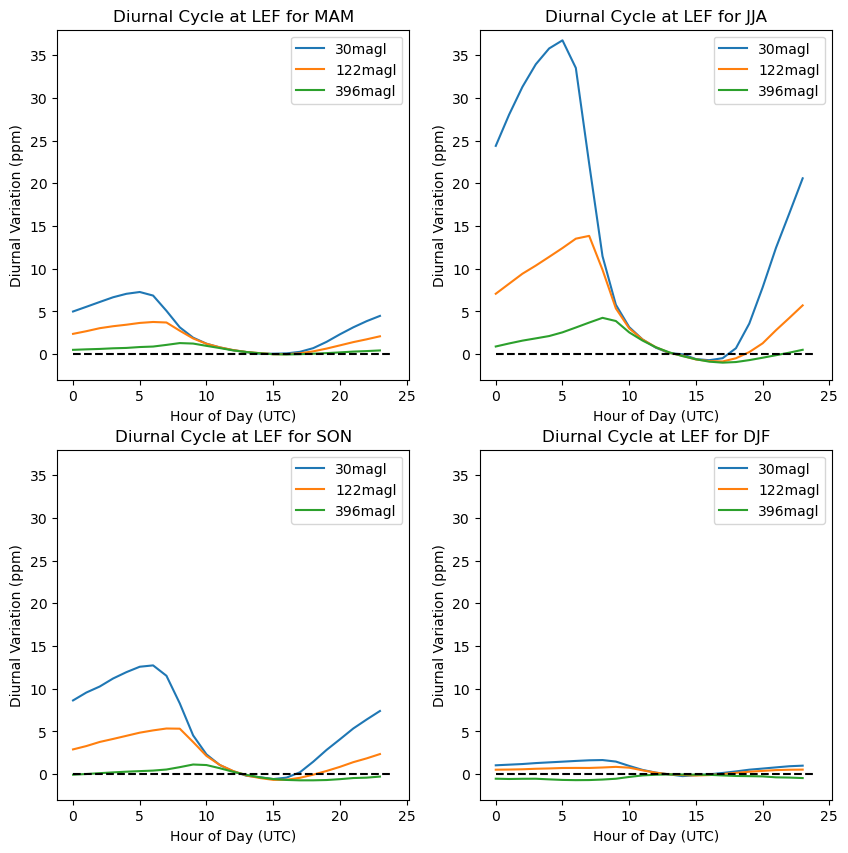

In [34]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
for isn,sn in enumerate(['MAM','JJA','SON','DJF']):
  ax = axs[isn//2,isn%2]
  for ky in heights:
    inds = np.where((lef_is_all[ky].index.month > 3*isn+2)*(lef_is_all[ky].index.month <= 3*isn+5))
    if sn == 'DJF':
      inds = np.where((lef_is_all[ky].index.month == 12) + (lef_is_all[ky].index.month < 3))
    ssn_ts = lef_is_all[ky].iloc[inds]
    ts = ssn_ts.groupby(ssn_ts['co2_de'].index.hour)['co2_de'].mean()
    ax.plot(ts)
  ax.legend(heights)
  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax.set_ylabel('Diurnal Variation (ppm)')
  ax.legend(heights)
  ax.set_ylim([-3,38])
  ax.plot([0,24],[0,0],'--k')
  ax.set_xlabel('Hour of Day (UTC)')

## Questions

1. Why did we choose the daytime data seasonality and trend to subtract? 
2. Why are the mole fractions in the 30m data so much larger than the others at nighttime, but overlap with the others in the daytime?
3. What drives the differences in daytime minimum mole fractions between the different seasons?
4. What drives the differences in nighttime maximum mole fractions between the different seasons?
5. What are we assuming about the statistics of the detrended, deseasonalized time series when we make these plots?

# Extra Credit: Analyze Correlations with Local Eddy Covariance Flux Observations
These data are taken from the Ameriflux measurement site maintained by Ankur Desai's group at the University of Wisconsin and hosted at https://ameriflux.lbl.gov/doi/AmeriFlux/US-PFa/.

Descriptions of variables can be found at https://ameriflux.lbl.gov/data/aboutdata/data-variables/.

**What is the spatial scale of flux sensed here**

In [35]:
ec = pd.read_csv(settings['ameriflux_file'],skiprows=2)

In [36]:
ec.keys()

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'CO2_1_1_1', 'CO2_1_2_1',
       'CO2_1_3_1', 'H2O_1_1_1', 'H2O_1_2_1', 'H2O_1_3_1', 'H2O_PI_F_1_3_1',
       'CH4_1_1_1', 'CH4_1_2_1', 'CH4_1_3_1', 'FC_1_1_1', 'FC_1_2_1',
       'FC_1_3_1', 'FCH4_1_1_1', 'SC_1_1_1', 'SC_1_2_1', 'SC_1_3_1',
       'SCH4_1_1_1', 'H', 'H_1_1_1', 'H_1_2_1', 'H_1_3_1', 'LE', 'LE_1_1_1',
       'LE_1_2_1', 'LE_1_3_1', 'SH_1_1_1', 'SH_1_2_1', 'SH_1_3_1', 'SLE_1_1_1',
       'SLE_1_2_1', 'SLE_1_3_1', 'WD_1_1_1', 'WD_1_2_1', 'WD_1_3_1',
       'WD_PI_F_1_3_1', 'WS_1_1_1', 'WS_1_2_1', 'WS_1_3_1', 'WS_PI_F_1_3_1',
       'USTAR_1_1_1', 'USTAR_1_2_1', 'USTAR_1_3_1', 'USTAR_PI_F_1_3_1',
       'PA_1_1_1', 'TA_1_1_1', 'TA_1_2_1', 'TA_1_3_1', 'TA_PI_F_1_3_1',
       'VPD_PI_F_1_3_1', 'SWC_1_1_1', 'PPFD_IN_1_1_1', 'P', 'NEE_PI',
       'NEE_PI_F', 'NEE_PI_1_1_1', 'NEE_PI_1_2_1', 'NEE_PI_1_3_1', 'RECO_PI_F',
       'GPP_PI_F', 'RH_1_3_1', 'SWC_2_1_1', 'SWC_2_2_1', 'SWC_2_3_1',
       'SWC_2_4_1', 'SWC_2_5_1', 'SWC_2_6_1', 'S

## First create a datetime index so we can do time series analysis

In [37]:
ts = ec['TIMESTAMP_START'].values
ts_str = [str(t) for t in ts]
YYYY = [int(t[:4]) for t in ts_str]
MM = [int(t[4:6]) for t in ts_str]
DD = [int(t[6:8]) for t in ts_str]
hh = [int(t[8:10]) for t in ts_str]
mm = [int(t[10:12]) for t in ts_str]
dts = np.array([dt.datetime(YYYY[i],MM[i],DD[i],hh[i],mm[i],0) + dt.timedelta(seconds=7*3600) for i in range(len(ts_str))])
solar_time = np.array([dts[i] + dt.timedelta(hours=-90.2723/180. * 12) for i in range(len(dts))])

#Convert UTC to Solar/Local Time
ec.index = solar_time

## Filter out bad data

In [38]:
ec.replace(-9999,np.nan,inplace=True)

## U$^*$ Filtering
We need to exclude data where the winds are not sufficiently turbulent to satisfy the eddy covariance flux theory:
https://www.bgc-jena.mpg.de/5624872/Ustar-filtering

**Simple explanation:** exclude data below a threshold u$^*$ value where the data has a strong linear dependency.  In general this threshold is seasonally dependent and site-specific.

(0.0, 10.0)

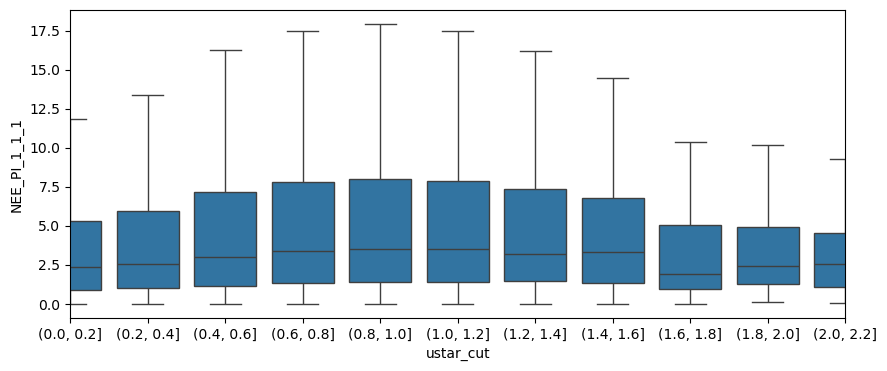

In [39]:
ec['ustar_cut'] = pd.cut(ec['USTAR_1_1_1'],np.arange(0,5,0.2))
plt.figure(figsize=(10,4))
sns.boxplot(x=ec['ustar_cut'],y=np.abs(ec['NEE_PI_1_1_1']),showfliers=False,)
plt.xlim([0,10])

### Net Ecosystem Exchange (NEE) with PI corrections (_PI) and gap filling (_F)

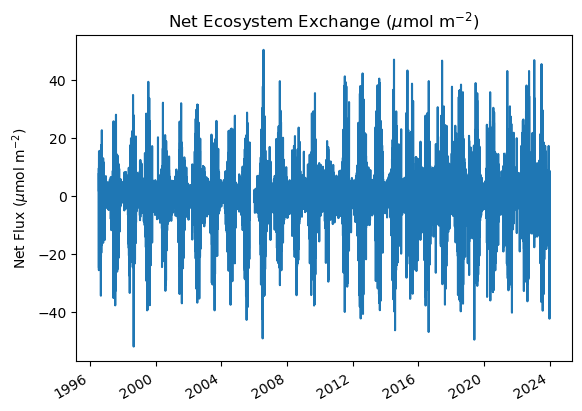

In [40]:
ec['NEE_PI_F'].plot(title='Net Ecosystem Exchange ($\mu$mol m$^{-2}$)',ylabel='Net Flux ($\mu$mol m$^{-2}$)');

### PIs separate the NEE into Gross Ecosystem Exchange (GEE) and Ecosystem Respiration (RECO) - typically temperature predicts RECO and GEE is taken as the residual flux.

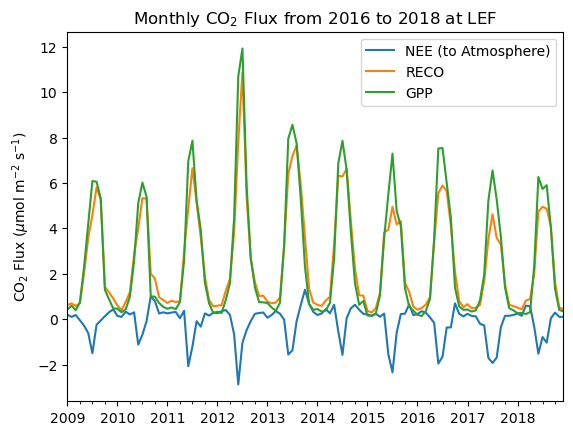

In [41]:
ec.NEE_PI_F.groupby(pd.Grouper(freq='m')).mean()[dt.datetime(2009,1,1):dt.datetime(2019,1,1)].plot()
ec.RECO_PI_F.groupby(pd.Grouper(freq='m')).mean()[dt.datetime(2009,1,1):dt.datetime(2019,1,1)].plot()
(ec.GPP_PI_F).groupby(pd.Grouper(freq='m')).mean()[dt.datetime(2009,1,1):dt.datetime(2019,1,1)].plot()
plt.legend(['NEE (to Atmosphere)','RECO','GPP'])
plt.ylabel('CO$_2$ Flux ($\mu$mol m$^{-2}$ s$^{-1}$)');
plt.title('Monthly CO$_2$ Flux from 2016 to 2018 at LEF');

### Seasonality of GPP and RECO tell us about ecosystem processes 

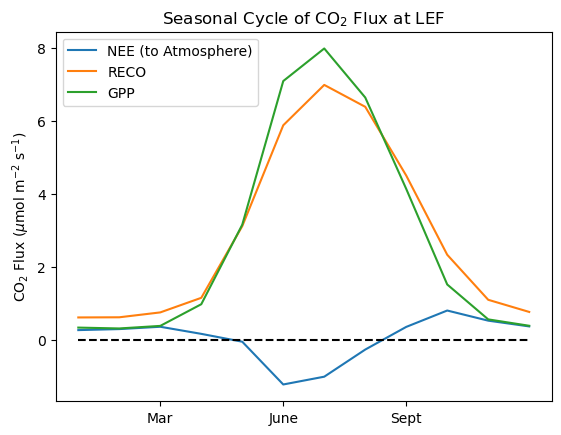

In [42]:
ec.NEE_PI_F.groupby(ec.index.month).mean().plot()
ec.RECO_PI_F.groupby(ec.index.month).mean().plot()
ec.GPP_PI_F.groupby(ec.index.month).mean().plot()
plt.legend(['NEE (to Atmosphere)','RECO','GPP'])
plt.ylabel('CO$_2$ Flux ($\mu$mol m$^{-2}$ s$^{-1}$)');
plt.title('Seasonal Cycle of CO$_2$ Flux at LEF');
plt.plot(np.array([1,12]),np.zeros(2),'--k')
plt.gca().set_xticks([3,6,9],['Mar','June','Sept']);

#### Questions:
1. What drives the seasonal cycle of GPP (i.e., photosynthesis)?
2. What drives the seasonal cycle of RECO? Does it make sense that it is correlated with GPP?
3. What drives the seasonal cycle of NEE?



## Now plot the diurnal net flux versus the de-trended, de-seasonalized mole fraction.

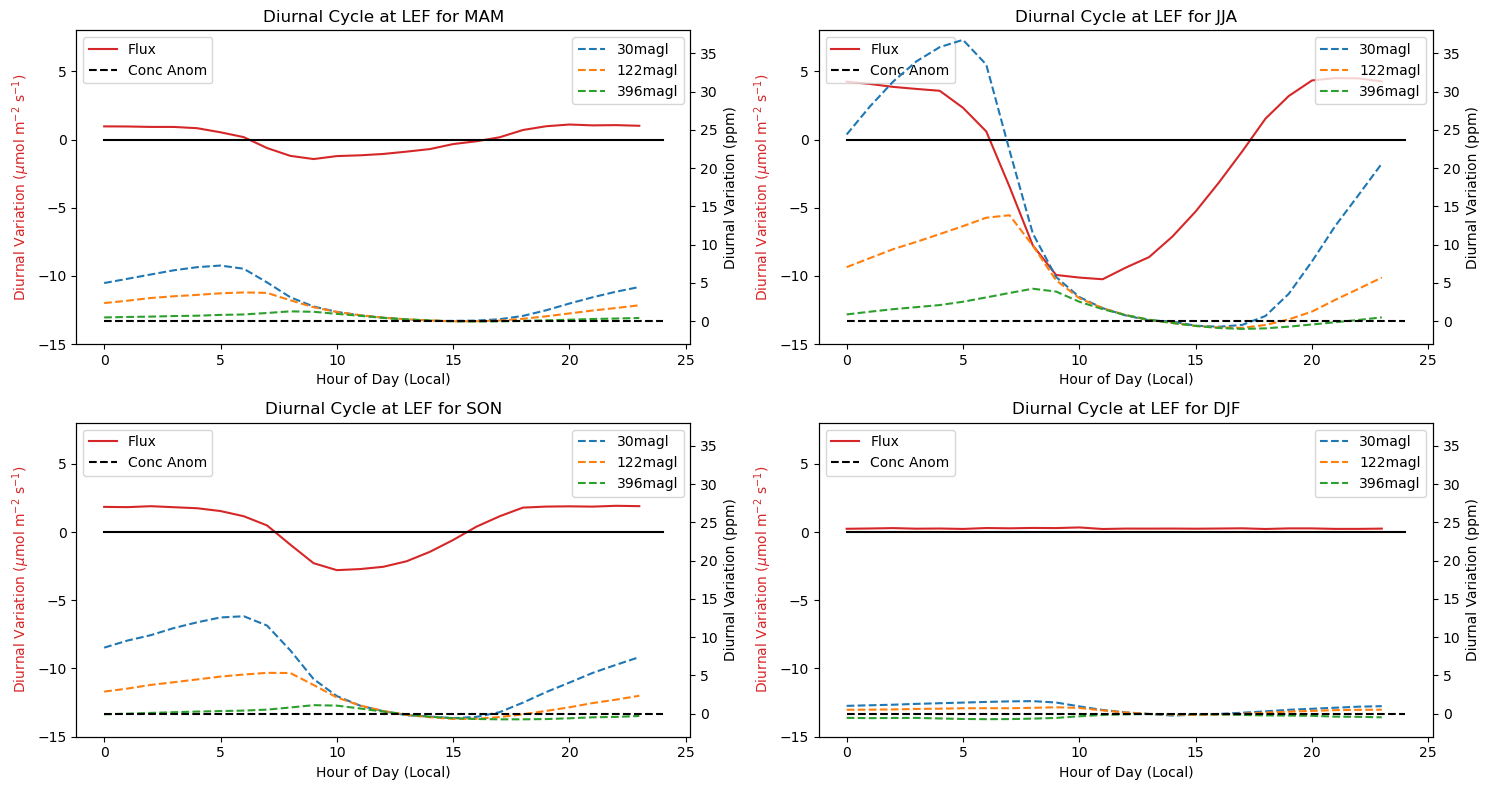

In [43]:
pt,lb = [],[]
pt.append(plt.plot([0,0],[1,1],color='tab:red'))
pt.append(plt.plot([0,0],[1,1],'--',color='k'))
plt.close()

fig,axs=plt.subplots(2,2,figsize=(15,8))
for isn,sn in enumerate(['MAM','JJA','SON','DJF']):
  ax = axs[isn//2,isn%2]
  ky = f'NEE_PI'
  inds = np.where((ec.index.month > 3*isn+2)*(ec.index.month <= 3*isn+5))
  if sn == 'DJF':
    inds = np.where((ec.index.month == 12) + (ec.index.month < 3))
  ssn_ts = ec.iloc[inds]
  ts = ssn_ts.groupby(ssn_ts.index.hour)[ky].mean()
  ax.plot(ts,color='tab:red')

  ax2 = ax.twinx()
  for ky in heights:
    inds = np.where((lef_is_all[ky].index.month > 3*isn+2)*(lef_is_all[ky].index.month <= 3*isn+5))
    if sn == 'DJF':
      inds = np.where((lef_is_all[ky].index.month == 12) + (lef_is_all[ky].index.month < 3))
    ssn_ts = lef_is_all[ky].iloc[inds]
    ts = ssn_ts.groupby(ssn_ts['co2_de'].index.hour)['co2_de'].mean()
    ax2.plot(ts,'--')
  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax.set_ylabel('Diurnal Variation ($\mu$mol m$^{-2}$ s$^{-1}$)',color='tab:red')
  ax2.set_ylim([-3,38])
  ax2.plot([0,24],[0,0],'--k')
  ax.legend([pt[0][0],pt[1][0]],['Flux','Conc Anom'],loc='upper left')

  ax.set_title(f'Diurnal Cycle at LEF for {sn}')
  ax2.set_ylabel('Diurnal Variation (ppm)')
  ax2.legend(heights)
  ax.set_ylim([-15,8])
  ax.plot([0,24],[0,0],'k')
  ax.set_xlabel('Hour of Day (Local)')
plt.tight_layout()

## Questions

1. What drives the differences in flux from season to season?
2. What drives the daily cycle of flux?
3. Are the flux and mole fraction time series correlated? Is there an obvious lag?  What would be causing that lag?